In [8]:
#!/usr/bin/env python3
"""
check_4tick_distribution.py
───────────────────────────
Compute label distribution on raw NQ DOM CSV data using a *4-tick* rule.

• Up   (label 0) : Δmid ≥ +4 ticks
• Stay (label 1) : |Δmid| < 4 ticks
• Down (label 2) : Δmid ≤ −4 ticks
"""

from __future__ import annotations
from pathlib import Path
import numpy as np
import pandas as pd

# ────────── USER SETTINGS ──────────────────────────────────────────────────
CSV_FILES   = [r"C:\Users\jiruszde\OneDrive\Main\1.Projects\My\Trading\Jupyter\2025-tlob\data\raw-sierra\dom-datatick.csv"]
RESAMPLE_TO = "1s"        # 1-second snapshots  (lower-case ‘s’ → no warning)
TICK_SIZE   = 0.25        # 1 tick for NQ
SMOOTH_LEN  = 1           # = LEN_SMOOTH in original repo
HORIZONS    = (2, 3, 4)
# ───────────────────────────────────────────────────────────────────────────

COLS = (
    ["timestamp"]
    + [f"ask_px{i}" for i in range(10)]
    + [f"bid_px{i}" for i in range(10)]    
    + [f"ask_sz{i}" for i in range(10)]
    + [f"bid_sz{i}" for i in range(10)]
    
)

# --------------------------------------------------------------------------
def read_one_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, header=None, names=COLS)

    df = _reorder_dom_block(df)

    # convert timestamp (unix-ms or ISO-8601) to pandas UTC
    if pd.api.types.is_numeric_dtype(df["timestamp"]):
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True,
                                         errors="coerce")
    else:
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True,
                                         errors="coerce", format="ISO8601")
    df = df.dropna(subset=["timestamp"])


    return df

# ------------------------------------------------------------------
# helper: reorder 40 DOM columns  (A A..A | B B..B | C C..C | D D..D)
#          → ask_px , ask_sz , bid_px , bid_sz  (level 0..9)
# ------------------------------------------------------------------
def _reorder_dom_block(df: pd.DataFrame) -> pd.DataFrame:
    """
    In-place rearrange the order-book columns so every level appears as
    Px / Sz alternation (needed by z_score_orderbook & labeling).
    """
    # split the four 10-column blocks
    ask_px = [f"ask_px{i}" for i in range(10)]
    bid_px = [f"bid_px{i}" for i in range(10)]
    ask_sz = [f"ask_sz{i}" for i in range(10)]
    bid_sz = [f"bid_sz{i}" for i in range(10)]

    # build the new column order
    new_cols = []
    for i in range(10):
        new_cols += [ask_px[i], ask_sz[i], bid_px[i], bid_sz[i]]

    # prepend the timestamp and reorder
    return df[["timestamp"] + new_cols]


def label_4ticks(ob: np.ndarray, h: int) -> np.ndarray:
    """
    Parameters
    ----------
    ob : ndarray, shape (T, 40)
         Sierra order  bidPx0…9 | bidSz0…9 | askPx0…9 | askSz0…9
    h  : int   horizon in snapshots

    Returns
    -------
    ndarray, shape (T-h,) with values 0 / 1 / 2
    """
    bid_px0 = ob[:, 10]    # best bid
    ask_px0 = ob[:, 0]   # best ask
    mid = (bid_px0 + ask_px0) / 2.0

    win_prev = np.lib.stride_tricks.sliding_window_view(mid, SMOOTH_LEN)[:-h]
    win_fut  = np.lib.stride_tricks.sliding_window_view(mid, SMOOTH_LEN)[h:]

    delta   = win_fut.mean(axis=1) - win_prev.mean(axis=1)
    thresh  = 4 * TICK_SIZE          # four ticks

    return np.where(delta >=  thresh, 0,
           np.where(delta <= -thresh, 2, 1))

# --------------------------------------------------------------------------
frames = [read_one_csv(Path(p)) for p in CSV_FILES]
df      = pd.concat(frames, ignore_index=True)
orderbk = df.drop(columns=["timestamp"]).to_numpy(dtype=np.float32)

print(f"\nTotal snapshots after resampling: {len(orderbk):,}")

for h in HORIZONS:
    y = label_4ticks(orderbk, h)
    vals, cnts = np.unique(y, return_counts=True)
    pct = cnts / cnts.sum()

    print(f"\nHorizon {h:>3} snapshots (~{h} s):")
    for v, n, p in zip(vals, cnts, pct):
        name = {0: 'UP', 1: 'STAY', 2: 'DOWN'}[v]
        print(f"  {name:<5}: {n:>8,}  ({p:6.3%})")

print("\nDone.")



Total snapshots after resampling: 982,338

Horizon   2 snapshots (~2 s):
  UP   :  432,614  (44.039%)
  STAY :  102,736  (10.458%)
  DOWN :  446,986  (45.502%)

Horizon   3 snapshots (~3 s):
  UP   :  448,468  (45.653%)
  STAY :   79,052  (8.047%)
  DOWN :  454,815  (46.299%)

Horizon   4 snapshots (~4 s):
  UP   :  457,119  (46.534%)
  STAY :   66,140  (6.733%)
  DOWN :  459,075  (46.733%)

Done.


Total 1-s snapshots in file(s): 982,338
Plotting first 1,800 snapshots


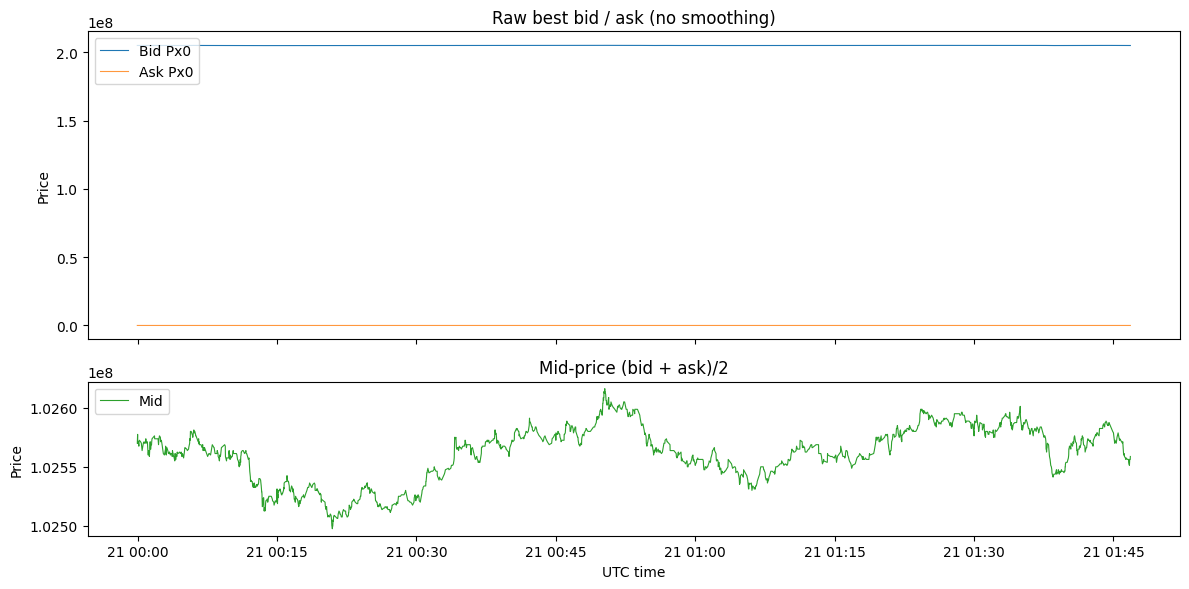

In [5]:
#!/usr/bin/env python3
"""
plot_mid_price.py
────────────────────────────────────────────────────────────────────────────
Two-panel sanity-check:

A. Raw best bid / ask after 1-second resampling (no smoothing)
B. Mid-price series used for Δ-tick label logic
"""

from __future__ import annotations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ───────── USER SETTINGS ──────────────────────────────────────────────────
CSV_FILES   = [r"C:\Users\jiruszde\OneDrive\Main\1.Projects\My\Trading\Jupyter\2025-tlob\data\raw-sierra\dom-datatick.csv"]
RESAMPLE_TO = "1s"        # lower-case ‘s’ = no future deprecation warning
MAX_POINTS  = 1800      # how many snapshots to plot
# ──────────────────────────────────────────────────────────────────────────

COLS = (
    ["timestamp"]
    + [f"bid_px{i}" for i in range(10)]
    + [f"bid_sz{i}" for i in range(10)]
    + [f"ask_px{i}" for i in range(10)]
    + [f"ask_sz{i}" for i in range(10)]
)

# -------------------------------------------------------------------------
def _read(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, names=COLS, header=None)

    # unix-epoch-ms *or* ISO-8601 → pandas UTC
    if pd.api.types.is_numeric_dtype(df["timestamp"]):
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms",
                                         utc=True, errors="coerce")
    else:
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True,
                                         errors="coerce", format="ISO8601")
    df = df.dropna(subset=["timestamp"])

    return df
# -------------------------------------------------------------------------

frames = [_read(Path(p)) for p in CSV_FILES]
df     = pd.concat(frames, ignore_index=True)

# first N points
n_plot = min(MAX_POINTS, len(df))
ts     = df["timestamp"].iloc[:n_plot]

# raw best bid / ask
bid0 = df["bid_px0"].to_numpy(float)[:n_plot]
ask0 = df["ask_px0"].to_numpy(float)[:n_plot]
mid  = (bid0 + ask0) / 2.0

print(f"Total 1-s snapshots in file(s): {len(df):,}")
print(f"Plotting first {n_plot:,} snapshots")

# ────────── PLOT ──────────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True,
                               gridspec_kw={"height_ratios": [2, 1]})

# Panel A – raw best bid / ask
ax1.plot(ts, bid0,  label="Bid Px0",  linewidth=0.8)
ax1.plot(ts, ask0,  label="Ask Px0",  linewidth=0.8, alpha=0.8)
ax1.set_title("Raw best bid / ask (no smoothing)")
ax1.set_ylabel("Price")
ax1.legend(loc="upper left")

# Panel B – mid-price
ax2.plot(ts, mid, color="tab:green", linewidth=0.8, label="Mid")
ax2.set_title("Mid-price (bid + ask)/2")
ax2.set_xlabel("UTC time")
ax2.set_ylabel("Price")
ax2.legend(loc="upper left")

fig.tight_layout()
plt.show()


Daily CSVs already exist – skipping re‑split.
Alpha: 0.00010680409103563201
Number of labels: (array([0, 1, 2]), array([  1784, 838543,   2046]))
Percentage of labels: [0.00211783 0.99545332 0.00242885]
Alpha: 0.00039345191442995207
Number of labels: (array([0, 1, 2]), array([   152, 186876,    145]))
Percentage of labels: [8.12082939e-04 9.98413233e-01 7.74684383e-04]
Alpha: 0.0004586931747379925
Number of labels: (array([0, 1, 2]), array([   476, 526863,    576]))
Percentage of labels: [9.01660305e-04 9.98007255e-01 1.09108474e-03]
Alpha: 0.0002242900513839257
Number of labels: (array([0, 1, 2]), array([  2292, 837497,   2574]))
Percentage of labels: [0.00272092 0.99422339 0.00305569]
Alpha: 0.0008355524818667902
Number of labels: (array([0, 1, 2]), array([   115, 186887,    161]))
Percentage of labels: [6.14437683e-04 9.98525350e-01 8.60212756e-04]
Alpha: 0.0009344646418432569
Number of labels: (array([0, 1, 2]), array([   543, 526679,    683]))
Percentage of labels: [0.00102859 0.9